In [4]:
import re

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.utils.data import DataLoader, TensorDataset

from rnn import RNN
from lstm import LSTM
from gru import GRU
from transformer import TransformerClassifier

In [5]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/rafkat/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rafkat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
df = pd.read_csv('../data/amazon_reviews.csv')
df.head(10)

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
5,positive,overall love this mouse the size weight clicki...,68,3.0
6,neutral,it stopped working,3,1.0
7,positive,my son uses school issued chromebook for schoo...,170,1.0
8,negative,loved this cute little mouse but it broke afte...,17,1.0
9,negative,should ve spent the money to get quality produ...,17,1.0


In [8]:
print(df.isna().sum())

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64


In [9]:
df = df.dropna()

In [10]:
print(df.isna().sum())

sentiments               0
cleaned_review           0
cleaned_review_length    0
review_score             0
dtype: int64


In [11]:
test_text = df['cleaned_review'][0]
print('Initial state: ', test_text)
regexped_text = re.sub(r'[^a-zA-Z\s]', '', test_text)
print('Used regexp: ', regexped_text)  # for cleaning text from 
tokenized_text = word_tokenize(regexped_text.lower())
print('Tokenized text: ', tokenized_text)
stop_words = set(stopwords.words('english'))
# print('Stop words: ', stop_words)
cleaned_text = [token for token in tokenized_text if token not in stop_words]
print('Cleaned text: ', cleaned_text)
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(token) for token in cleaned_text]
print('Lemmatized text: ', tokens)

Initial state:  i wish would have gotten one earlier love it and it makes working in my laptop so much easier
Used regexp:  i wish would have gotten one earlier love it and it makes working in my laptop so much easier
Tokenized text:  ['i', 'wish', 'would', 'have', 'gotten', 'one', 'earlier', 'love', 'it', 'and', 'it', 'makes', 'working', 'in', 'my', 'laptop', 'so', 'much', 'easier']
Cleaned text:  ['wish', 'would', 'gotten', 'one', 'earlier', 'love', 'makes', 'working', 'laptop', 'much', 'easier']
Lemmatized text:  ['wish', 'would', 'gotten', 'one', 'earlier', 'love', 'make', 'working', 'laptop', 'much', 'easier']


In [12]:
def text_preprocessing(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [13]:
df.loc[:, 'cleaned_review'] = df['cleaned_review'].apply(text_preprocessing)

In [14]:
df['cleaned_review']

0        wish would gotten one earlier love make workin...
1        learned lesson open package use product right ...
2                              slow lag find better option
3        roller ball stopped working within month minim...
4            like color size day return period hold charge
                               ...                        
17335    love speaker love take anywhere charge phone w...
17336              use house easy connect loud clear music
17337    bass good battery amazing much better charge t...
17338                                                 love
17339                                         mono speaker
Name: cleaned_review, Length: 17337, dtype: object

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

In [16]:
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = pd.get_dummies(df['sentiments']).values
labels

array([[False, False,  True],
       [False,  True, False],
       [False,  True, False],
       ...,
       [False, False,  True],
       [False, False,  True],
       [False,  True, False]])

In [17]:
max_len

313

In [18]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [19]:
train_data = TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float())
val_data = TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float())
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=50, shuffle=True)

In [20]:
res = next(iter(train_loader))
res[0].shape, res[0].dtype, res[1].shape

(torch.Size([50, 313]), torch.int64, torch.Size([50, 3]))

In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
def train_and_validate(model_, optimizer, criterion_, train_loader_, val_loader_, epochs_, device_):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs_):
        model_.train()
        total_train_loss = 0
        for inputs, labels_ in train_loader_:
            inputs, labels_ = inputs.to(device_), labels_.to(device_)
            output = model_(inputs)
            print(output, labels_)
            loss = criterion_(output, torch.max(labels_, 1)[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model_.eval()
        total_val_loss, total_acc = 0, 0
        with torch.no_grad():
            for inputs, labels_ in val_loader_:
                inputs, labels_ = inputs.to(device_), labels_.to(device_)
                output = model_(inputs)
                val_loss = criterion_(output, torch.max(labels_, 1)[1])
                total_val_loss += val_loss.item()
                acc = accuracy(output, torch.max(labels_, 1)[1])
                total_acc += acc.item()

        avg_train_loss = total_train_loss / len(train_loader_)
        avg_val_loss = total_val_loss / len(val_loader_)
        avg_acc = total_acc / len(val_loader_)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_acc)
        print(
            f'Epoch: {epoch + 1}/{epochs_}, Train loss: {avg_train_loss}, Val loss: {avg_val_loss}, Val acc: {avg_acc}')
    return train_losses, val_losses, val_accs

In [25]:
def plot_losses(model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# RNN

In [26]:
epochs = 20
output_size_ = 3
embedding_dim_ = 400
hidden_dim_ = 256
n_layers_ = 2
vocab_size = len(tokenizer.word_index) + 1

model = RNN(output_size_, embedding_dim_, hidden_dim_, n_layers_, vocab_size).to(device)

In [27]:
rnn_optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [28]:
print('RNN Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, rnn_optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNN Start Training:
tensor([[ 0.5116,  0.3012,  0.0515],
        [ 0.4704, -0.1999,  0.0359],
        [ 0.1647, -0.4559, -0.1153],
        [ 0.2471,  0.1727, -0.3427],
        [-0.1989,  0.0677, -0.1223],
        [-0.1894, -0.0756, -0.3837],
        [ 0.1238, -0.3718,  0.0331],
        [-0.2215, -0.1156,  0.2417],
        [ 0.4554, -0.1106, -0.4053],
        [ 0.1264, -0.0616, -0.0847],
        [ 0.0308,  0.1908, -0.0315],
        [ 0.0435, -0.4588,  0.0561],
        [ 0.0837,  0.0683, -0.2378],
        [-0.3587, -0.0887, -0.0599],
        [-0.0053, -0.2701,  0.0353],
        [ 0.2744,  0.4830, -0.4747],
        [ 0.4530, -0.4640,  0.2018],
        [-0.1193, -0.2140,  0.1499],
        [ 0.2662, -0.1392, -0.3945],
        [-0.0370,  0.0433, -0.1795],
        [ 0.1398, -0.2448, -0.1049],
        [ 0.0038,  0.2261,  0.3121],
        [-0.0111, -0.0559, -0.2522],
        [-0.0774, -0.1361, -0.0288],
        [ 0.3099, -0.0673, -0.1484],
        [ 0.1400, -0.1080,  0.0824],
        [ 0.1966, 

KeyboardInterrupt: 

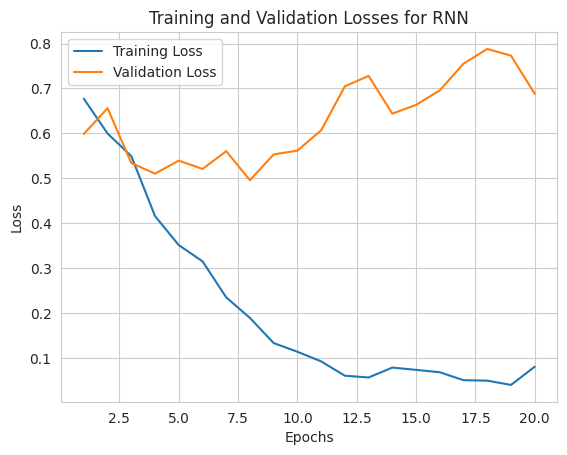

In [100]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

# BiDirectional RNN

In [21]:
epochs = 20
output_size_ = 3
embedding_dim_ = 400
hidden_dim_ = 256
n_layers_ = 2
vocab_size = len(tokenizer.word_index) + 1
modes = 'sum'

model = RNN(output_size_, embedding_dim_, hidden_dim_, n_layers_, vocab_size, modes).to(device)

In [22]:
rnn_optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [23]:
print('BiDirRNN Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, rnn_optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

BiDirRNN Start Training:
Epoch: 1/20, Train loss: 0.706047852155116, Val loss: 0.6156641142708915, Val acc: 0.7589523826326643
Epoch: 2/20, Train loss: 0.5575437590801459, Val loss: 0.5987467893532344, Val acc: 0.7499682545661926
Epoch: 3/20, Train loss: 0.5070622556929966, Val loss: 0.5726200448615211, Val acc: 0.7794920572212765
Epoch: 4/20, Train loss: 0.4255317833891018, Val loss: 0.5494497028844697, Val acc: 0.7888888827392033
Epoch: 5/20, Train loss: 0.33835845159219324, Val loss: 0.5130739808082581, Val acc: 0.8167618981429509
Epoch: 6/20, Train loss: 0.27198457688414795, Val loss: 0.5232140077011925, Val acc: 0.8276190417153495
Epoch: 7/20, Train loss: 0.23328696502868435, Val loss: 0.5379830398729869, Val acc: 0.814317455462047
Epoch: 8/20, Train loss: 0.30940960227049513, Val loss: 0.5635801196098328, Val acc: 0.8185396816049303
Epoch: 9/20, Train loss: 0.21225806966209584, Val loss: 0.572207046193736, Val acc: 0.8364761863436018
Epoch: 10/20, Train loss: 0.1266857984093882, 

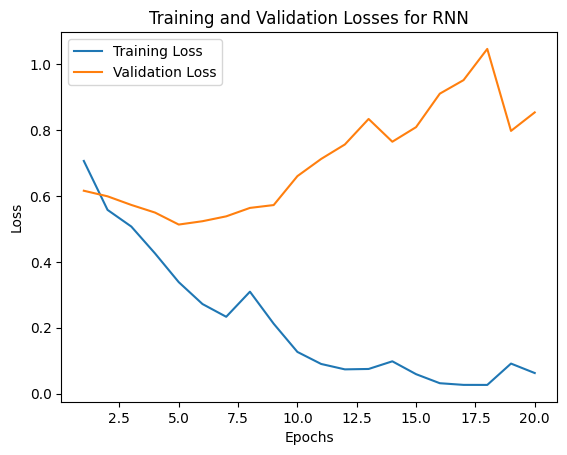

In [26]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

# LSTM 

In [24]:
epochs = 20
output_size_ = 3
embedding_dim_ = 400
hidden_dim_ = 256
n_layers_ = 2
vocab_size = len(tokenizer.word_index) + 1

model = LSTM(output_size_, embedding_dim_, hidden_dim_, n_layers_, vocab_size).to(device)

In [25]:
lstm_optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [26]:
print('LSTM Start Training:')
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(model, lstm_optimizer, criterion, train_loader,
                                                                       val_loader, epochs, device)

LSTM Start Training:
Epoch: 1/20, Train loss: 0.8340027875823083, Val loss: 0.6650721899100712, Val acc: 0.6973333375794547
Epoch: 2/20, Train loss: 0.5644878321628777, Val loss: 0.533589471238, Val acc: 0.7635238093989236
Epoch: 3/20, Train loss: 0.4672482982813883, Val loss: 0.47270879532609666, Val acc: 0.7973333299160004
Epoch: 4/20, Train loss: 0.37573757103021194, Val loss: 0.42697300825800216, Val acc: 0.8260952293872833
Epoch: 5/20, Train loss: 0.3157996447395078, Val loss: 0.43204993328877855, Val acc: 0.8340634856905256
Epoch: 6/20, Train loss: 0.2300288919091439, Val loss: 0.4264995181134769, Val acc: 0.8464126936026982
Epoch: 7/20, Train loss: 0.16399338858858717, Val loss: 0.39828311928680965, Val acc: 0.8667618972914559
Epoch: 8/20, Train loss: 0.11010866477857713, Val loss: 0.40983255548136577, Val acc: 0.8766984071050371
Epoch: 9/20, Train loss: 0.07396430832588469, Val loss: 0.5148160934448243, Val acc: 0.8710476125989641
Epoch: 10/20, Train loss: 0.04938577149874068, 

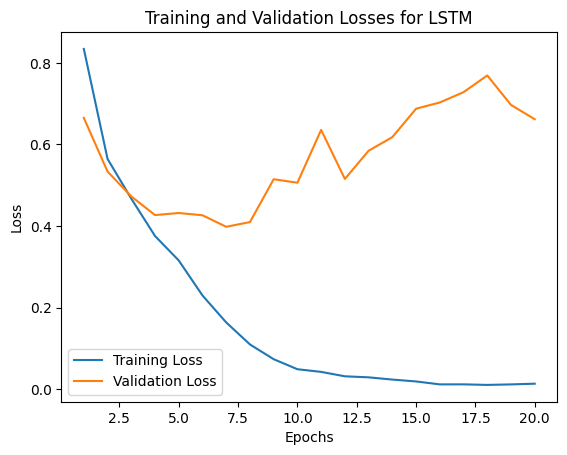

In [27]:
plot_losses('LSTM', lstm_train_losses, lstm_val_losses, epochs)

#  BiDirectional LSTM 

In [28]:
epochs = 20
output_size_ = 3
embedding_dim_ = 400
hidden_dim_ = 256
n_layers_ = 2
vocab_size = len(tokenizer.word_index) + 1
modes = 'sum'

model = LSTM(output_size_, embedding_dim_, hidden_dim_, n_layers_, vocab_size, modes).to(device)

In [29]:
lstm_optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [31]:
print('BiDirLSTM Start Training:')
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(model, lstm_optimizer, criterion, train_loader,
                                                                       val_loader, epochs, device)

BiDirLSTM Start Training:
Epoch: 1/20, Train loss: 0.77959238796783, Val loss: 0.599071261712483, Val acc: 0.7286031808171953
Epoch: 2/20, Train loss: 0.5122967211784218, Val loss: 0.49750981756619045, Val acc: 0.7913968205451966
Epoch: 3/20, Train loss: 0.4067765812543656, Val loss: 0.43472453228064944, Val acc: 0.8252698370388576
Epoch: 4/20, Train loss: 0.32031224215094994, Val loss: 0.39086121576172966, Val acc: 0.8488253934042794
Epoch: 5/20, Train loss: 0.2336415573284566, Val loss: 0.3962119279163224, Val acc: 0.8524126921381269
Epoch: 6/20, Train loss: 0.16348970205717378, Val loss: 0.412863898064409, Val acc: 0.8742857098579406
Epoch: 7/20, Train loss: 0.11209425051435293, Val loss: 0.41074513622692654, Val acc: 0.8817777752876281
Epoch: 8/20, Train loss: 0.0784030460682195, Val loss: 0.45013914917196546, Val acc: 0.873841266972678
Epoch: 9/20, Train loss: 0.04886390931616209, Val loss: 0.6097617111035756, Val acc: 0.8788888803550176
Epoch: 10/20, Train loss: 0.042344040763329

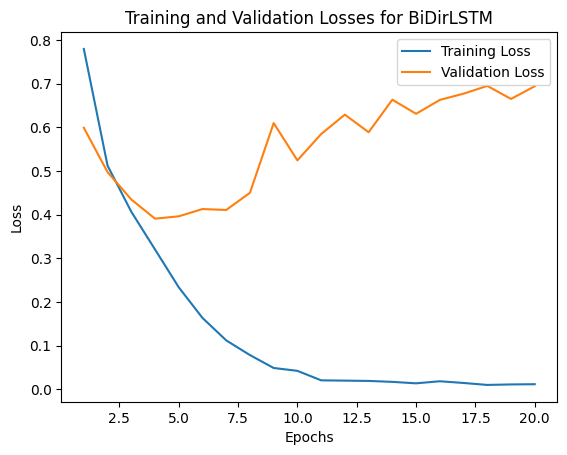

In [32]:
plot_losses('BiDirLSTM', lstm_train_losses, lstm_val_losses, epochs)

# GRU 

In [24]:
epochs = 20
output_size_ = 3
embedding_dim_ = 400
hidden_dim_ = 256
n_layers_ = 2
vocab_size = len(tokenizer.word_index) + 1

model = GRU(output_size_, embedding_dim_, hidden_dim_, n_layers_, vocab_size).to(device)

In [25]:
gru_optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [26]:
print('GRU Start Training:')
gru_train_losses, gru_val_losses, gru_val_accs = train_and_validate(model, gru_optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

GRU Start Training:
Epoch: 1/20, Train loss: 0.6993926118174902, Val loss: 0.574567129782268, Val acc: 0.7643809497356415
Epoch: 2/20, Train loss: 0.5103194901197077, Val loss: 0.4972050845623016, Val acc: 0.8041269821780068
Epoch: 3/20, Train loss: 0.43413157016038895, Val loss: 0.45873730182647704, Val acc: 0.8216825331960406
Epoch: 4/20, Train loss: 0.37321872333828493, Val loss: 0.4628149564777102, Val acc: 0.8235555512564523
Epoch: 5/20, Train loss: 0.3217005652489422, Val loss: 0.41260091279234207, Val acc: 0.8449206301144191
Epoch: 6/20, Train loss: 0.2678161750433685, Val loss: 0.42042651772499084, Val acc: 0.8470476124967847
Epoch: 7/20, Train loss: 0.22248248761291983, Val loss: 0.4309091436011451, Val acc: 0.85628570829119
Epoch: 8/20, Train loss: 0.17305162992569612, Val loss: 0.4375724877629961, Val acc: 0.8645396743501935
Epoch: 9/20, Train loss: 0.1334296471151195, Val loss: 0.4569305383733341, Val acc: 0.8725396743842534
Epoch: 10/20, Train loss: 0.09604672485252293, Va

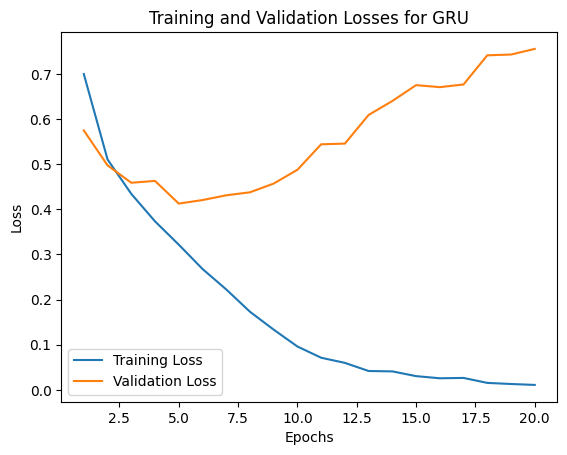

In [27]:
plot_losses('GRU', gru_train_losses, gru_val_losses, epochs)

#  BiDirectional GRU 

In [28]:
epochs = 20
output_size_ = 3
embedding_dim_ = 400
hidden_dim_ = 256
n_layers_ = 2
vocab_size = len(tokenizer.word_index) + 1
modes = 'sum'

model = GRU(output_size_, embedding_dim_, hidden_dim_, n_layers_, vocab_size, modes).to(device)

In [29]:
gru_optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [30]:
print('BiDirGRU Start Training:')
gru_train_losses, gru_val_losses, gru_val_accs = train_and_validate(model, gru_optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

BiDirGRU Start Training:
Epoch: 1/20, Train loss: 0.6982696109967266, Val loss: 0.5653119117021561, Val acc: 0.7829206330435616
Epoch: 2/20, Train loss: 0.5053787685448318, Val loss: 0.4998053393193654, Val acc: 0.8080317429133824
Epoch: 3/20, Train loss: 0.43354337978706087, Val loss: 0.45221791182245524, Val acc: 0.8232063429696219
Epoch: 4/20, Train loss: 0.3805149297276847, Val loss: 0.43734365488801685, Val acc: 0.833174593108041
Epoch: 5/20, Train loss: 0.33205192814842405, Val loss: 0.4286359035543033, Val acc: 0.8355555491788047
Epoch: 6/20, Train loss: 0.2909802966784659, Val loss: 0.4331833344485079, Val acc: 0.8516825352396283
Epoch: 7/20, Train loss: 0.25118796945475846, Val loss: 0.43298286284719195, Val acc: 0.8488888851233891
Epoch: 8/20, Train loss: 0.20893801377563598, Val loss: 0.41970257056610927, Val acc: 0.8614920565060207
Epoch: 9/20, Train loss: 0.1779072313777191, Val loss: 0.436081617644855, Val acc: 0.8586349121161869
Epoch: 10/20, Train loss: 0.15038511634757

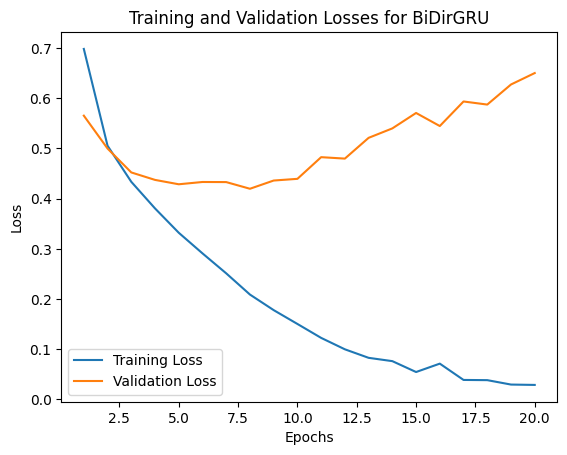

In [33]:
plot_losses('BiDirGRU', gru_train_losses, gru_val_losses, epochs)

#  Transformer 

In [26]:
epochs = 20
output_size_ = 3
embedding_dim_ = 400
n_layers_ = 4
vocab_size = len(tokenizer.word_index) + 1

model = TransformerClassifier(vocab_size, max_len, embedding_dim_, enc_depth=n_layers_, nb_classes=output_size_).to(device)

In [27]:
transformer_optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [28]:
print('Transformer Start Training:')
transformer_train_losses, transformer_val_losses, transformer_val_accs = train_and_validate(model, transformer_optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

Transformer Start Training:
Epoch: 1/20, Train loss: 0.8390450218169809, Val loss: 0.6900117473942893, Val acc: 0.7178730181285313
Epoch: 2/20, Train loss: 0.6222459829325299, Val loss: 0.5999750311885561, Val acc: 0.7636190465518407
Epoch: 3/20, Train loss: 0.5846622257138328, Val loss: 0.550015680704798, Val acc: 0.7783174557345254
Epoch: 4/20, Train loss: 0.4981162909337943, Val loss: 0.4664200676339013, Val acc: 0.8173333295754024
Epoch: 5/20, Train loss: 0.45352049595374855, Val loss: 0.5062308468988963, Val acc: 0.7812380961009434
Epoch: 6/20, Train loss: 0.4227334161242135, Val loss: 0.42930548169783184, Val acc: 0.8288888803550175
Epoch: 7/20, Train loss: 0.38481671111189203, Val loss: 0.4072585878627641, Val acc: 0.839682537317276
Epoch: 8/20, Train loss: 0.36267952304735457, Val loss: 0.4128485185759408, Val acc: 0.8386031653199877
Epoch: 9/20, Train loss: 0.32461511405359067, Val loss: 0.3914913705417088, Val acc: 0.8546984093529838
Epoch: 10/20, Train loss: 0.28995787818654

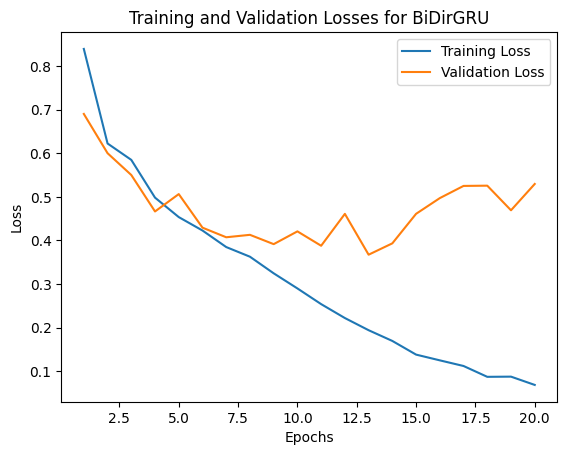

In [29]:
plot_losses('BiDirGRU', transformer_train_losses, transformer_val_losses, epochs)